<a href="https://colab.research.google.com/github/Krishna-Kumar-Sankaran-Kutty/PersonalFinanceUtils/blob/main/GetMFData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Dependencies

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

Define function to extract portfolio details from given url from Moneycontrol Portfolio Holdings page

In [59]:
def extract_portfolio(url):
  # Send an HTTP GET request to the URL
  response = requests.get(url)

  # Parse the HTML content using BeautifulSoup
  soup = BeautifulSoup(response.content, 'html.parser')

  # Find the table element
  table = soup.find('table', id='equityCompleteHoldingTable')

  # Extract table headers
  headers = [header.text.strip() for header in table.find_all('th')]

  # Extract table rows
  rows = []
  for row in table.find_all('tr')[1:]:  # Skip the header row
    data = [cell.text.strip() for cell in row.find_all('td')]
    rows.append(data)

  # Create a Pandas DataFrame
  df = pd.DataFrame(rows, columns=headers)

  # Add Fund Name column
  df['Fund Name'] = url.split('/')[-3].replace('-', ' ').title()

  # Set Fund Name column as index
  df = df.set_index('Fund Name')

  # Clean-up 'Stock Invested in' column
  df['Stock Invested in'] = df['Stock Invested in'].str.replace('#\n', '')

  # Clean-up '% of Total Holdings' column nad convert to float
  df['% of Total Holdings'] = df['% of Total Holdings'].str.rstrip('%').astype(float)

  # Drop all columns except 'Stock Invested in', 'Sector Total', and '% of Total Holdings'
  df = df[['Stock Invested in', '% of Total Holdings']]

  return df

In [62]:
url = 'https://www.moneycontrol.com/mutual-funds/hdfc-index-fund-nifty-50-plan-direct-plan/portfolio-holdings/MHD1152'

N50_Index = extract_portfolio(url)
N50_Index.head()

,Stock Invested in,% of Total Holdings
Fund Name,,
Hdfc Index Fund Nifty 50 Plan Direct Plan,HDFC Bank Ltd.,11.02
Hdfc Index Fund Nifty 50 Plan Direct Plan,Reliance Industries Ltd.,9.22
Hdfc Index Fund Nifty 50 Plan Direct Plan,ICICI Bank Ltd.,7.74
Hdfc Index Fund Nifty 50 Plan Direct Plan,Infosys Ltd.,6.11
Hdfc Index Fund Nifty 50 Plan Direct Plan,ITC Limited,4.14


In [63]:
url = 'https://www.moneycontrol.com/mutual-funds/parag-parikh-flexi-cap-fund-direct-plan/portfolio-holdings/MPP002'

PPFAS_FC = extract_portfolio(url)
PPFAS_FC.head()

,Stock Invested in,% of Total Holdings
Fund Name,,
Parag Parikh Flexi Cap Fund Direct Plan,HDFC Bank Ltd.,8.03
Parag Parikh Flexi Cap Fund Direct Plan,Power Grid Corporation of India Ltd.,6.86
Parag Parikh Flexi Cap Fund Direct Plan,Bajaj Holdings & Investment Ltd.,6.50
Parag Parikh Flexi Cap Fund Direct Plan,ITC Limited,5.76
Parag Parikh Flexi Cap Fund Direct Plan,Coal India Ltd.,5.75


In [74]:
url = 'https://www.moneycontrol.com/mutual-funds/hdfc-nifty-next-50-index-fund-direct-plan/portfolio-holdings/MHD3484'

N_Next_50_Index = extract_portfolio(url)
N_Next_50_Index.head()

,Stock Invested in,% of Total Holdings
Fund Name,,
Hdfc Nifty Next 50 Index Fund Direct Plan,Trent Limited,5.62
Hdfc Nifty Next 50 Index Fund Direct Plan,Bharat Electronics Ltd.,4.95
Hdfc Nifty Next 50 Index Fund Direct Plan,Hindustan Aeronautics Ltd.,4.03
Hdfc Nifty Next 50 Index Fund Direct Plan,Power Finance Corporation Ltd.,3.53
Hdfc Nifty Next 50 Index Fund Direct Plan,Rural Electrification Corporation Limited,3.48


In [77]:
# prompt: create a venn diagram showing overlap between PPFAS_FC and N50_Index

from matplotlib_venn import venn2
from matplotlib import pyplot as plt

# Extract the stock names from the DataFrames
ppfas_stocks = set(PPFAS_FC['Stock Invested in'])
n50_stocks = set(N50_Index['Stock Invested in'])
n_next50_stocks = set(N_Next_50_Index['Stock Invested in'])

# Create the Venn diagram
venn2([ppfas_stocks, n50_stocks, n_next50_stocks], set_labels=('PPFAS Flexi Cap', 'Nifty 50 Index', 'Nifty Next 50 Index'))
plt.title('Overlap of Stocks')
plt.show()


TypeError: bad operand type for abs(): 'set'

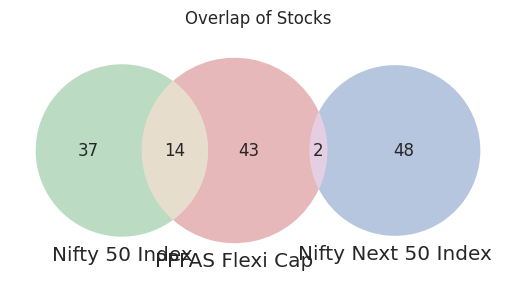

In [80]:
# prompt: create a single venn diagram with all three funds using the data frames for the three funds

from matplotlib_venn import venn3

# Create the Venn diagram with three sets
venn3([ppfas_stocks, n50_stocks, n_next50_stocks], set_labels=('PPFAS Flexi Cap', 'Nifty 50 Index', 'Nifty Next 50 Index'))
plt.title('Overlap of Stocks')
plt.show()
